<font face="Times New Roman" size=5>
<div dir=rtl align="center">
<font face="Times New Roman" size=5>
In The Name of God
</font>
<br>
<img src="https://logoyar.com/content/wp-content/uploads/2021/04/sharif-university-logo.png" alt="University Logo" width="150" height="150">
<br>
<font face="Times New Roman" size=4 align=center>
Sharif University of Technology - Department of Electrical Engineering
</font>
<br>
<font color="#008080" size=6>
Deep Generative Models
</font>

<hr/>
<font color="#800080" size=5>
Assignment 3: Generative Adversarial Networks
<br>
</font>
<font size=5>
Instructor: Dr. S. Amini
<br>
</font>
<font size=4>
Fall 2024
<br>
</font>
<font face="Times New Roman" size=4>
Deadline: Month day at 23:55
</font>
<hr>
</div></font>

In [ ]:
name = 'amirmahdi meighani'
std_id = '400105274'

### In this notebook, you will implement the required components from scratch, without code completion. Utilize `torch` to create models and perform optimization. The goal of this assignment is to implement Deep Convolutional Generative Adversarial Networks (DC-GAN) using the MNIST dataset and to explore interpolation in the latent space.

### To get started, please read the DC-GAN paper available at this link: [DC-GAN Paper](https://arxiv.org/abs/1511.06434v2).


### Part 1. Load the MNIST dataset.

In [7]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision import datasets, transforms
from IPython.display import HTML

import itertools
import math

In [2]:
batch_size = 128

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.13, ), std=(0.3,)),
])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.22MB/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



### Part 2: Build the Generator and Discriminator models.
Build the models with the architecture guidelines for stable training as described in the paper. It is recommended to use the model parameters presented in `config.yaml`, but you are free to choose any set of parameters you prefer.


In [3]:
class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(

                nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
                nn.BatchNorm2d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
                nn.Sigmoid()
            )
    def forward(self, input):
        output = self.network(input)
        return output.view(-1, 1).squeeze(1)


class Generator(nn.Module):
    def __init__(self, nc, nz, ngf):
      super(Generator, self).__init__()
      self.network = nn.Sequential(
          nn.ConvTranspose2d(nz, ngf*4, 4, 1, 0, bias=False),
          nn.BatchNorm2d(ngf*4),
          nn.ReLU(True),

          nn.ConvTranspose2d(ngf*4, ngf*2, 3, 2, 1, bias=False),
          nn.BatchNorm2d(ngf*2),
          nn.ReLU(True),

          nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
          nn.BatchNorm2d(ngf),
          nn.ReLU(True),

          nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
          nn.Tanh()
      )

    def forward(self, input):
      output = self.network(input)
      return output



### Part 3: Write a function to train the models using the GAN framework.
You can refer to the slides or the original GAN paper for the training schema: [GAN Paper](https://arxiv.org/abs/1406.2661). Additionally, create a function to generate samples from the model. Ensure to plot a grid of generated samples every n'th epoch.


In [4]:
def display_generated_images(epoch, fixed_noise, num_test_samples, netG, device):

    size_figure_grid = int(math.sqrt(num_test_samples))

    generated_fake_images = netG(fixed_noise)

    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)
    for k in range(num_test_samples):
        i = k // size_figure_grid
        j = k % size_figure_grid
        ax[i, j].cla()
        ax[i, j].imshow(generated_fake_images[k].data.cpu().numpy().reshape(28, 28), cmap='Greys')
    label = 'Epoch_{}'.format(epoch + 1)
    fig.text(0.5, 0.04, label, ha='center')
    plt.show()

Using cuda
Epoch [1/50], Step [100/469], D Loss: 0.1289, G Loss: 4.7742, D(x): 0.96, D(G(z)): 0.07/0.01
Epoch [1/50], Step [200/469], D Loss: 0.0241, G Loss: 6.0553, D(x): 0.98, D(G(z)): 0.01/0.00
Epoch [1/50], Step [300/469], D Loss: 0.0323, G Loss: 6.6113, D(x): 0.98, D(G(z)): 0.01/0.00
Epoch [1/50], Step [400/469], D Loss: 0.0189, G Loss: 7.8661, D(x): 0.99, D(G(z)): 0.00/0.00


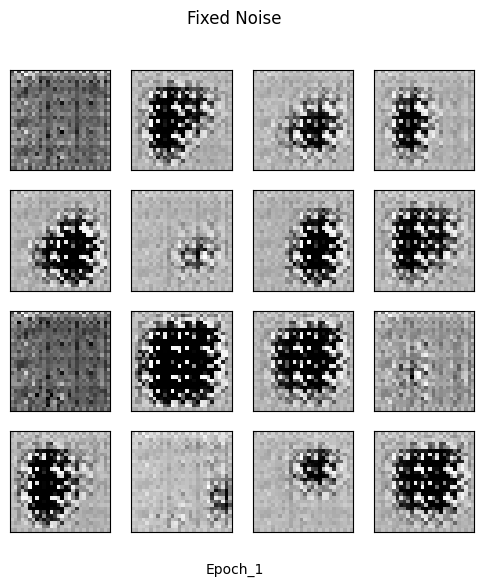

Epoch [2/50], Step [100/469], D Loss: 0.0046, G Loss: 7.2743, D(x): 1.00, D(G(z)): 0.00/0.00
Epoch [2/50], Step [200/469], D Loss: 0.0071, G Loss: 6.5493, D(x): 1.00, D(G(z)): 0.00/0.00
Epoch [2/50], Step [300/469], D Loss: 0.0036, G Loss: 7.5377, D(x): 1.00, D(G(z)): 0.00/0.00
Epoch [2/50], Step [400/469], D Loss: 0.0036, G Loss: 8.3036, D(x): 1.00, D(G(z)): 0.00/0.00


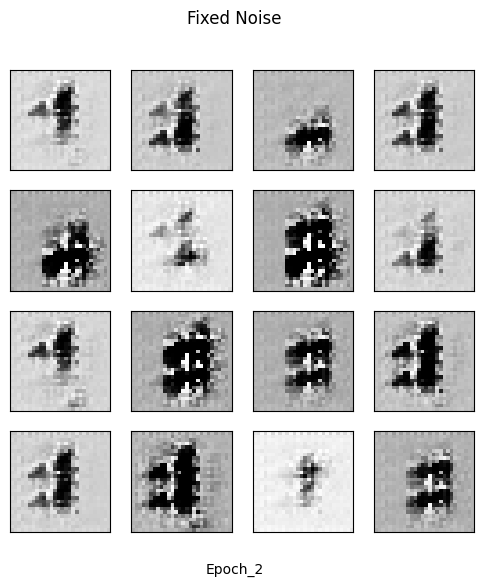

Epoch [3/50], Step [100/469], D Loss: 0.0012, G Loss: 7.5502, D(x): 1.00, D(G(z)): 0.00/0.00
Epoch [3/50], Step [200/469], D Loss: 0.0131, G Loss: 6.3343, D(x): 1.00, D(G(z)): 0.01/0.00
Epoch [3/50], Step [300/469], D Loss: 0.0053, G Loss: 7.2525, D(x): 1.00, D(G(z)): 0.00/0.00
Epoch [3/50], Step [400/469], D Loss: 0.0012, G Loss: 7.6433, D(x): 1.00, D(G(z)): 0.00/0.00


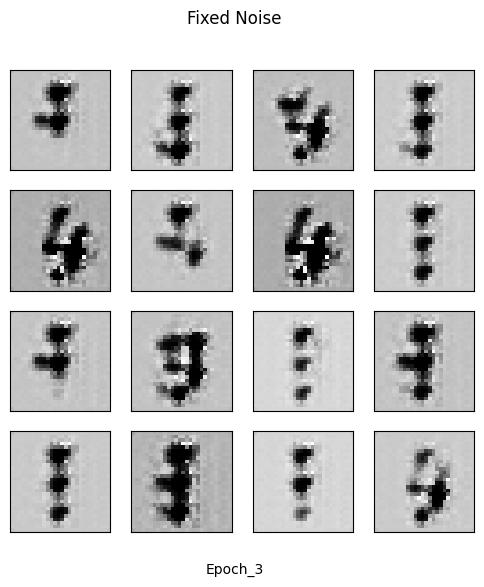

Epoch [4/50], Step [100/469], D Loss: 0.0016, G Loss: 6.5884, D(x): 1.00, D(G(z)): 0.00/0.00
Epoch [4/50], Step [200/469], D Loss: 0.0018, G Loss: 10.3816, D(x): 1.00, D(G(z)): 0.00/0.00
Epoch [4/50], Step [300/469], D Loss: 0.0020, G Loss: 8.7661, D(x): 1.00, D(G(z)): 0.00/0.00
Epoch [4/50], Step [400/469], D Loss: 0.0012, G Loss: 8.1978, D(x): 1.00, D(G(z)): 0.00/0.00


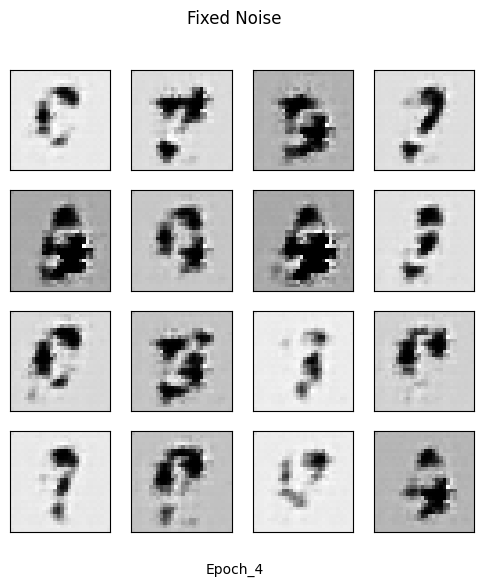

Epoch [5/50], Step [100/469], D Loss: 0.0361, G Loss: 5.6444, D(x): 0.98, D(G(z)): 0.01/0.01
Epoch [5/50], Step [200/469], D Loss: 0.0258, G Loss: 5.2970, D(x): 0.99, D(G(z)): 0.01/0.01
Epoch [5/50], Step [300/469], D Loss: 0.0100, G Loss: 6.7242, D(x): 0.99, D(G(z)): 0.00/0.00
Epoch [5/50], Step [400/469], D Loss: 0.0151, G Loss: 6.1004, D(x): 0.99, D(G(z)): 0.00/0.00


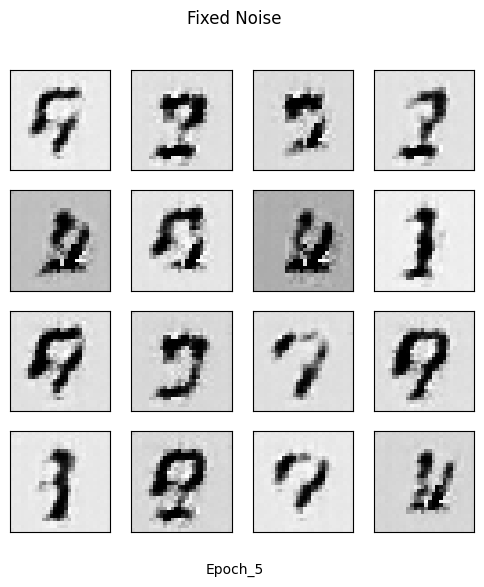

Epoch [6/50], Step [100/469], D Loss: 0.0093, G Loss: 5.5357, D(x): 1.00, D(G(z)): 0.01/0.01
Epoch [6/50], Step [200/469], D Loss: 0.0111, G Loss: 7.2508, D(x): 0.99, D(G(z)): 0.00/0.00
Epoch [6/50], Step [300/469], D Loss: 0.0081, G Loss: 8.0475, D(x): 0.99, D(G(z)): 0.00/0.00
Epoch [6/50], Step [400/469], D Loss: 0.0124, G Loss: 6.6159, D(x): 0.99, D(G(z)): 0.00/0.00


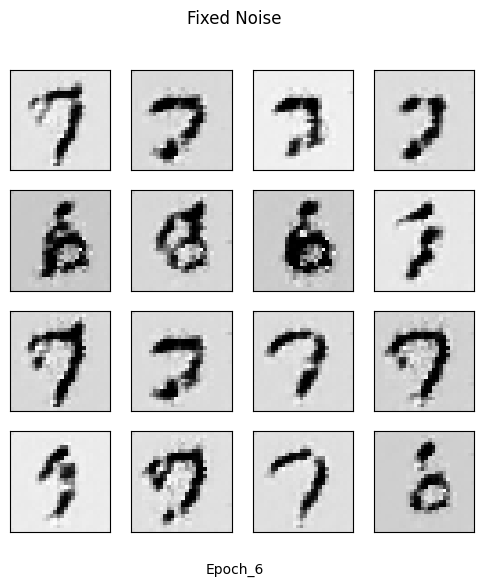

Epoch [7/50], Step [100/469], D Loss: 0.0071, G Loss: 6.2915, D(x): 1.00, D(G(z)): 0.00/0.00
Epoch [7/50], Step [200/469], D Loss: 0.0115, G Loss: 6.5752, D(x): 0.99, D(G(z)): 0.00/0.00
Epoch [7/50], Step [300/469], D Loss: 0.0154, G Loss: 7.0281, D(x): 0.99, D(G(z)): 0.00/0.00
Epoch [7/50], Step [400/469], D Loss: 0.0107, G Loss: 5.8826, D(x): 1.00, D(G(z)): 0.01/0.01


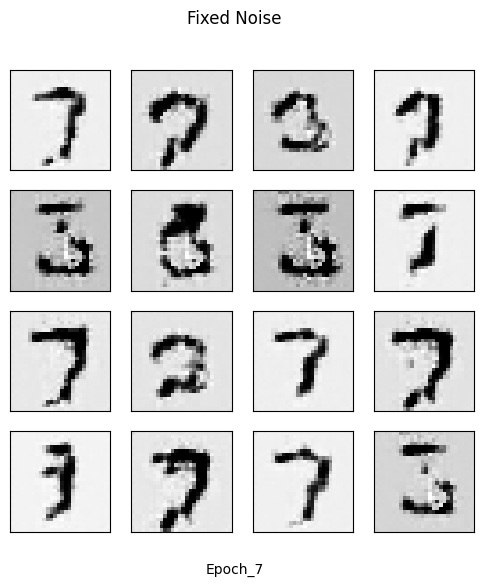

Epoch [8/50], Step [100/469], D Loss: 0.0060, G Loss: 7.6810, D(x): 1.00, D(G(z)): 0.00/0.00
Epoch [8/50], Step [200/469], D Loss: 0.0512, G Loss: 5.7401, D(x): 0.99, D(G(z)): 0.03/0.01
Epoch [8/50], Step [300/469], D Loss: 0.0100, G Loss: 6.1840, D(x): 1.00, D(G(z)): 0.01/0.00
Epoch [8/50], Step [400/469], D Loss: 0.0180, G Loss: 6.0710, D(x): 0.99, D(G(z)): 0.01/0.01


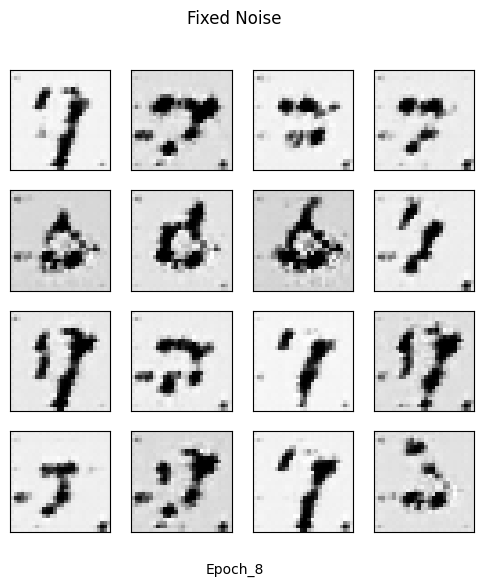

Epoch [9/50], Step [100/469], D Loss: 0.0168, G Loss: 5.4729, D(x): 1.00, D(G(z)): 0.01/0.01
Epoch [9/50], Step [200/469], D Loss: 0.0060, G Loss: 6.5851, D(x): 1.00, D(G(z)): 0.00/0.00
Epoch [9/50], Step [300/469], D Loss: 0.0165, G Loss: 4.8786, D(x): 1.00, D(G(z)): 0.01/0.01
Epoch [9/50], Step [400/469], D Loss: 0.0091, G Loss: 6.0766, D(x): 1.00, D(G(z)): 0.01/0.01


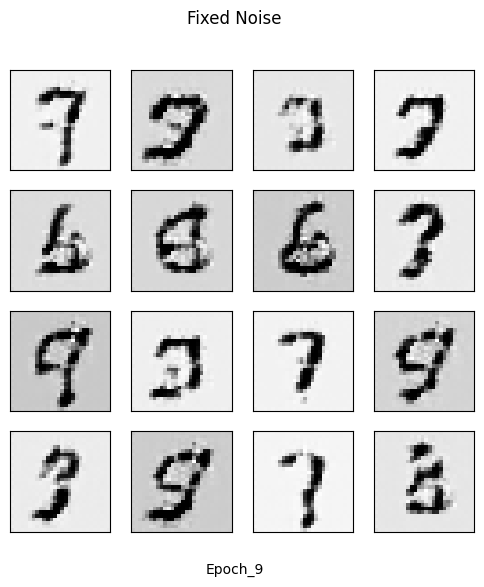

Epoch [10/50], Step [100/469], D Loss: 0.0187, G Loss: 6.1454, D(x): 0.99, D(G(z)): 0.00/0.00
Epoch [10/50], Step [200/469], D Loss: 0.0081, G Loss: 6.6544, D(x): 1.00, D(G(z)): 0.00/0.00
Epoch [10/50], Step [300/469], D Loss: 0.0156, G Loss: 6.3522, D(x): 0.99, D(G(z)): 0.00/0.00
Epoch [10/50], Step [400/469], D Loss: 0.0548, G Loss: 5.5853, D(x): 0.99, D(G(z)): 0.04/0.01


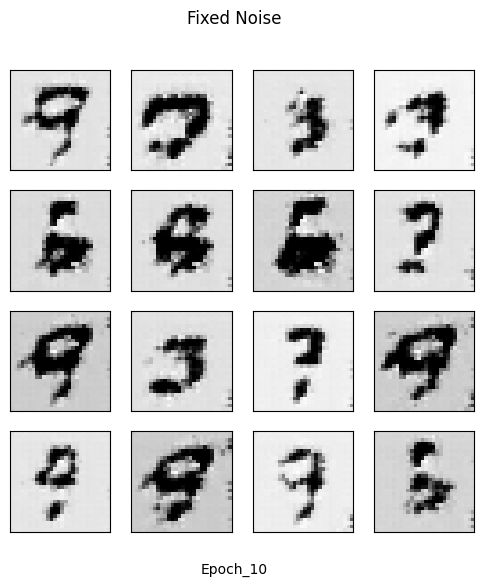

Epoch [11/50], Step [100/469], D Loss: 0.0101, G Loss: 5.6189, D(x): 1.00, D(G(z)): 0.01/0.01
Epoch [11/50], Step [200/469], D Loss: 0.0106, G Loss: 6.7090, D(x): 0.99, D(G(z)): 0.00/0.00
Epoch [11/50], Step [300/469], D Loss: 0.0161, G Loss: 6.4460, D(x): 0.99, D(G(z)): 0.00/0.00
Epoch [11/50], Step [400/469], D Loss: 0.0165, G Loss: 6.7880, D(x): 0.99, D(G(z)): 0.01/0.00


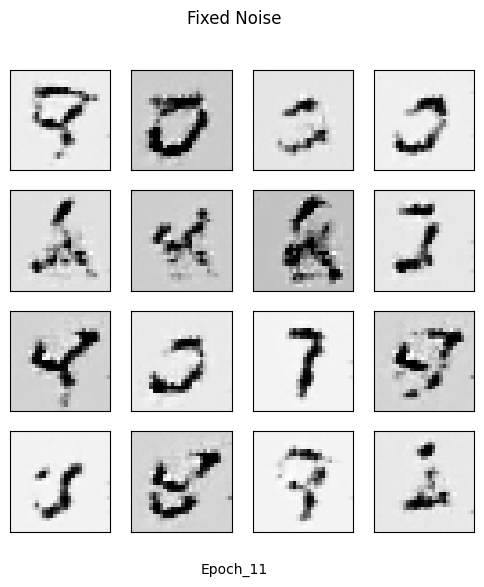

Epoch [12/50], Step [100/469], D Loss: 0.0517, G Loss: 7.3885, D(x): 0.96, D(G(z)): 0.00/0.00
Epoch [12/50], Step [200/469], D Loss: 0.0254, G Loss: 4.6487, D(x): 0.99, D(G(z)): 0.02/0.02
Epoch [12/50], Step [300/469], D Loss: 0.0212, G Loss: 6.2089, D(x): 0.99, D(G(z)): 0.01/0.00
Epoch [12/50], Step [400/469], D Loss: 0.0287, G Loss: 5.4415, D(x): 0.98, D(G(z)): 0.01/0.01


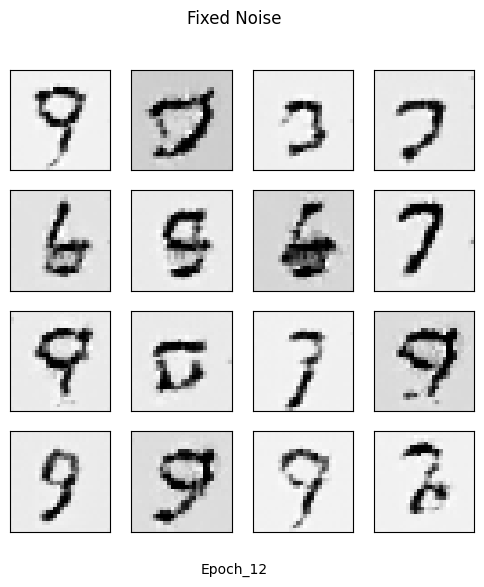

Epoch [13/50], Step [100/469], D Loss: 0.0092, G Loss: 6.5047, D(x): 1.00, D(G(z)): 0.01/0.00
Epoch [13/50], Step [200/469], D Loss: 0.0204, G Loss: 6.3589, D(x): 1.00, D(G(z)): 0.02/0.01
Epoch [13/50], Step [300/469], D Loss: 0.0717, G Loss: 5.2557, D(x): 1.00, D(G(z)): 0.06/0.02
Epoch [13/50], Step [400/469], D Loss: 0.0153, G Loss: 6.5065, D(x): 0.99, D(G(z)): 0.01/0.01


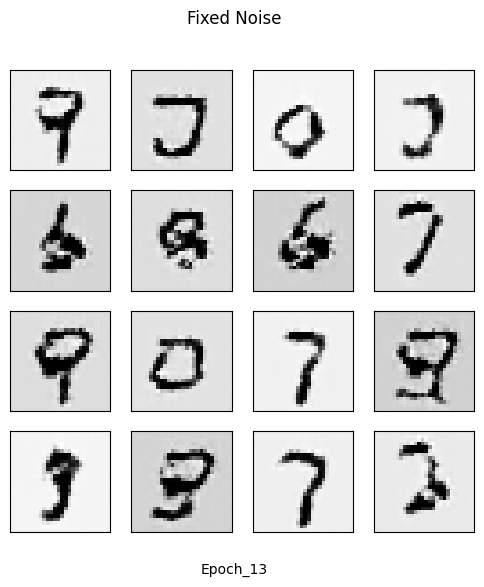

Epoch [14/50], Step [100/469], D Loss: 0.0145, G Loss: 8.7345, D(x): 0.99, D(G(z)): 0.00/0.00
Epoch [14/50], Step [200/469], D Loss: 0.0607, G Loss: 5.5518, D(x): 0.95, D(G(z)): 0.01/0.01
Epoch [14/50], Step [300/469], D Loss: 0.0333, G Loss: 7.5080, D(x): 0.98, D(G(z)): 0.01/0.00
Epoch [14/50], Step [400/469], D Loss: 0.0385, G Loss: 6.5950, D(x): 0.97, D(G(z)): 0.01/0.00


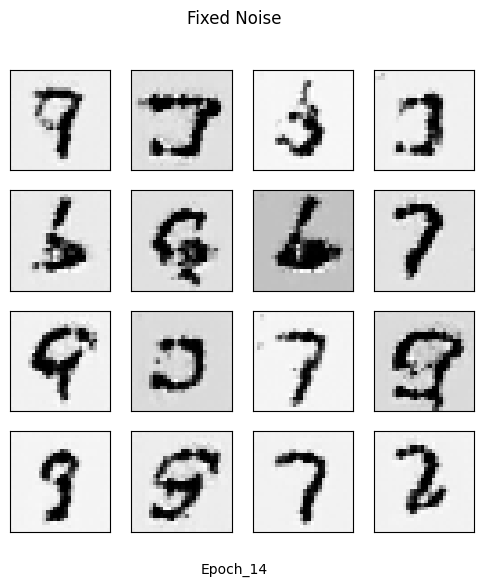

Epoch [15/50], Step [100/469], D Loss: 0.0803, G Loss: 5.5242, D(x): 0.94, D(G(z)): 0.00/0.01
Epoch [15/50], Step [200/469], D Loss: 0.0313, G Loss: 6.7966, D(x): 0.98, D(G(z)): 0.01/0.00
Epoch [15/50], Step [300/469], D Loss: 0.0579, G Loss: 5.0453, D(x): 0.96, D(G(z)): 0.01/0.02
Epoch [15/50], Step [400/469], D Loss: 0.0353, G Loss: 9.1250, D(x): 0.97, D(G(z)): 0.00/0.00


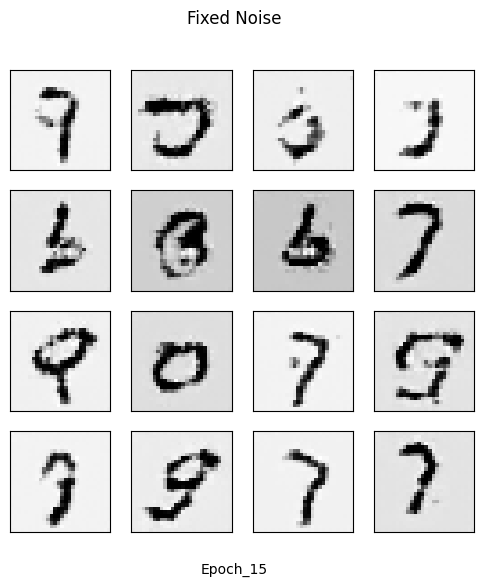

Epoch [16/50], Step [100/469], D Loss: 0.0613, G Loss: 4.9223, D(x): 0.97, D(G(z)): 0.02/0.03
Epoch [16/50], Step [200/469], D Loss: 0.0290, G Loss: 4.9666, D(x): 0.99, D(G(z)): 0.01/0.02
Epoch [16/50], Step [300/469], D Loss: 0.0501, G Loss: 5.1875, D(x): 0.97, D(G(z)): 0.01/0.02
Epoch [16/50], Step [400/469], D Loss: 0.0312, G Loss: 4.4293, D(x): 0.99, D(G(z)): 0.02/0.03


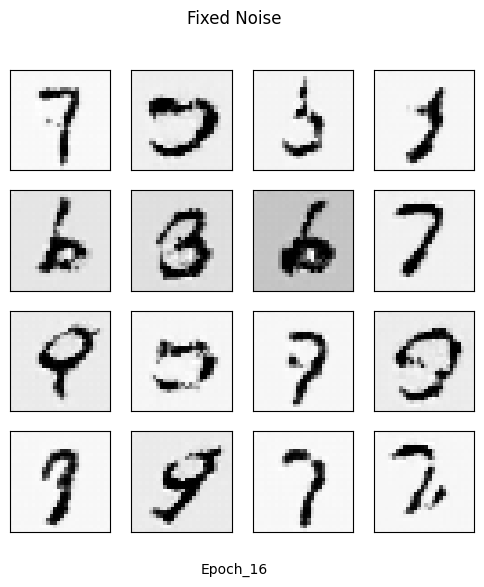

Epoch [17/50], Step [100/469], D Loss: 0.0416, G Loss: 7.0054, D(x): 0.98, D(G(z)): 0.01/0.00
Epoch [17/50], Step [200/469], D Loss: 0.0483, G Loss: 5.7545, D(x): 1.00, D(G(z)): 0.04/0.01
Epoch [17/50], Step [300/469], D Loss: 0.0707, G Loss: 5.7357, D(x): 0.95, D(G(z)): 0.01/0.01
Epoch [17/50], Step [400/469], D Loss: 0.0485, G Loss: 5.3800, D(x): 0.99, D(G(z)): 0.03/0.01


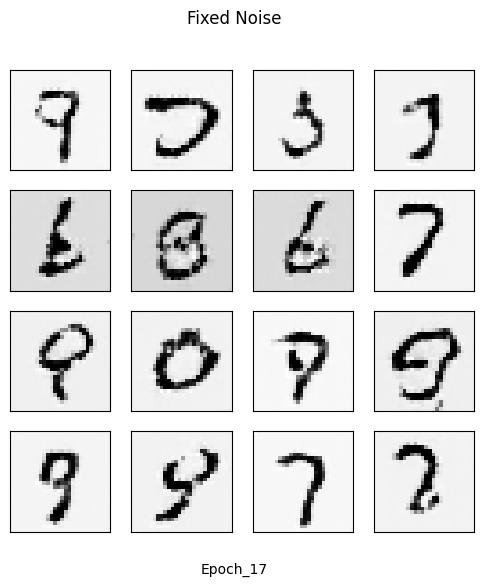

Epoch [18/50], Step [100/469], D Loss: 0.0998, G Loss: 5.2915, D(x): 0.94, D(G(z)): 0.02/0.02
Epoch [18/50], Step [200/469], D Loss: 0.0439, G Loss: 9.4206, D(x): 0.96, D(G(z)): 0.00/0.00
Epoch [18/50], Step [300/469], D Loss: 0.2535, G Loss: 5.2165, D(x): 0.82, D(G(z)): 0.01/0.02
Epoch [18/50], Step [400/469], D Loss: 0.0824, G Loss: 4.7896, D(x): 0.94, D(G(z)): 0.01/0.02


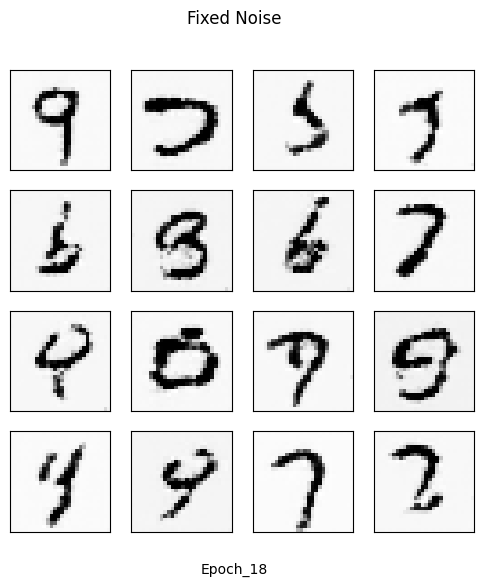

Epoch [19/50], Step [100/469], D Loss: 0.0664, G Loss: 4.0250, D(x): 0.97, D(G(z)): 0.03/0.04
Epoch [19/50], Step [200/469], D Loss: 0.0882, G Loss: 4.4052, D(x): 0.97, D(G(z)): 0.05/0.03
Epoch [19/50], Step [300/469], D Loss: 0.0578, G Loss: 5.4532, D(x): 0.98, D(G(z)): 0.03/0.01
Epoch [19/50], Step [400/469], D Loss: 0.0327, G Loss: 5.8296, D(x): 0.99, D(G(z)): 0.02/0.01


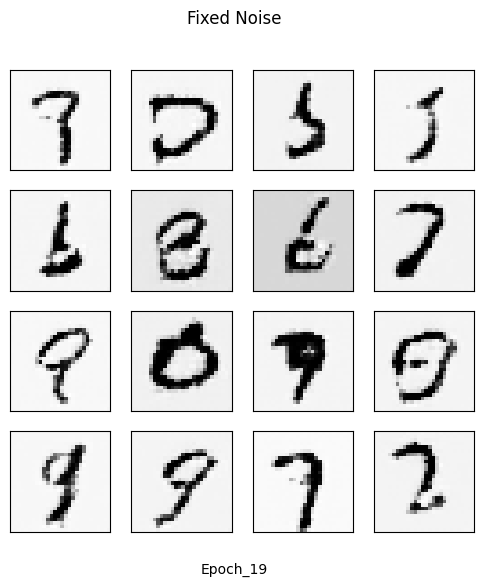

Epoch [20/50], Step [100/469], D Loss: 0.1097, G Loss: 3.5842, D(x): 0.98, D(G(z)): 0.08/0.05
Epoch [20/50], Step [200/469], D Loss: 0.0618, G Loss: 4.9776, D(x): 0.97, D(G(z)): 0.03/0.01
Epoch [20/50], Step [300/469], D Loss: 0.0967, G Loss: 7.5323, D(x): 0.94, D(G(z)): 0.01/0.00
Epoch [20/50], Step [400/469], D Loss: 0.0435, G Loss: 5.8769, D(x): 0.97, D(G(z)): 0.01/0.01


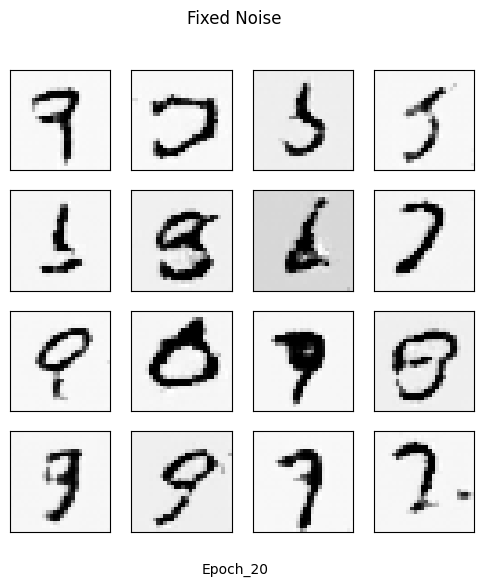

Epoch [21/50], Step [100/469], D Loss: 0.2164, G Loss: 3.0916, D(x): 0.89, D(G(z)): 0.07/0.08
Epoch [21/50], Step [200/469], D Loss: 0.0798, G Loss: 6.1015, D(x): 0.94, D(G(z)): 0.01/0.01
Epoch [21/50], Step [300/469], D Loss: 0.1369, G Loss: 2.4518, D(x): 0.94, D(G(z)): 0.06/0.15
Epoch [21/50], Step [400/469], D Loss: 0.0648, G Loss: 3.7778, D(x): 0.96, D(G(z)): 0.02/0.05


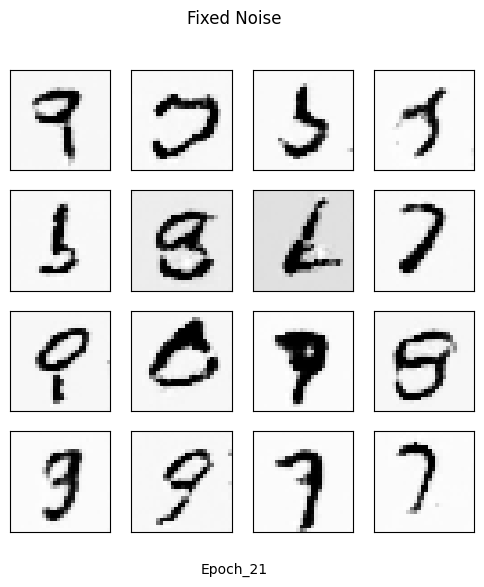

Epoch [22/50], Step [100/469], D Loss: 0.1493, G Loss: 4.3178, D(x): 0.92, D(G(z)): 0.06/0.03
Epoch [22/50], Step [200/469], D Loss: 0.0918, G Loss: 5.3708, D(x): 0.98, D(G(z)): 0.06/0.02
Epoch [22/50], Step [300/469], D Loss: 0.1695, G Loss: 3.9119, D(x): 0.87, D(G(z)): 0.02/0.04
Epoch [22/50], Step [400/469], D Loss: 0.0521, G Loss: 3.5678, D(x): 0.96, D(G(z)): 0.01/0.07


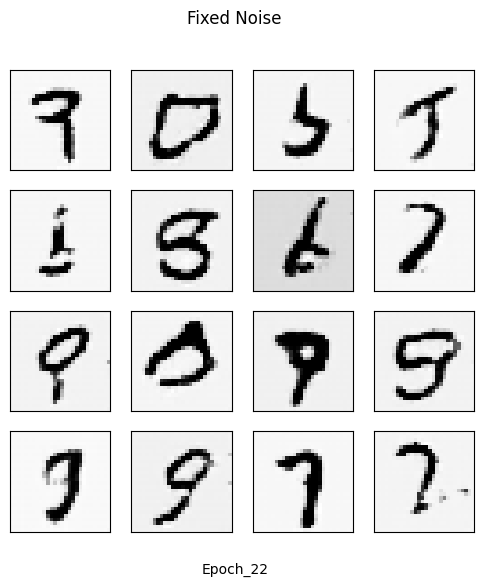

Epoch [23/50], Step [100/469], D Loss: 0.1018, G Loss: 4.8271, D(x): 0.92, D(G(z)): 0.01/0.02
Epoch [23/50], Step [200/469], D Loss: 0.0554, G Loss: 4.2330, D(x): 0.97, D(G(z)): 0.02/0.03
Epoch [23/50], Step [300/469], D Loss: 0.1370, G Loss: 4.4303, D(x): 0.96, D(G(z)): 0.08/0.03
Epoch [23/50], Step [400/469], D Loss: 0.4493, G Loss: 3.3891, D(x): 0.97, D(G(z)): 0.30/0.06


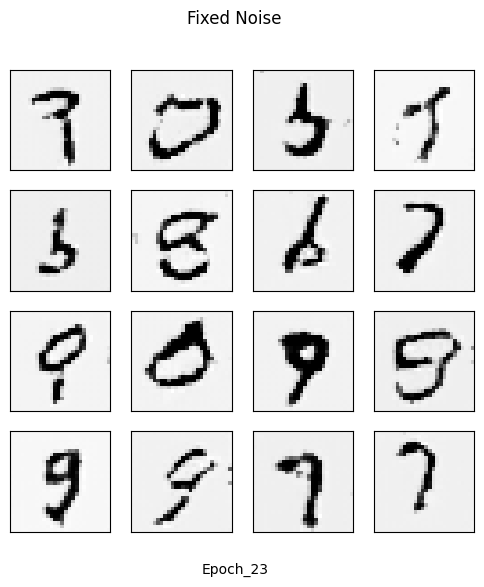

Epoch [24/50], Step [100/469], D Loss: 0.1408, G Loss: 2.7300, D(x): 0.98, D(G(z)): 0.10/0.12
Epoch [24/50], Step [200/469], D Loss: 0.2852, G Loss: 5.1084, D(x): 0.95, D(G(z)): 0.17/0.02
Epoch [24/50], Step [300/469], D Loss: 0.2361, G Loss: 3.2723, D(x): 0.94, D(G(z)): 0.14/0.08
Epoch [24/50], Step [400/469], D Loss: 0.3277, G Loss: 3.7884, D(x): 0.77, D(G(z)): 0.02/0.04


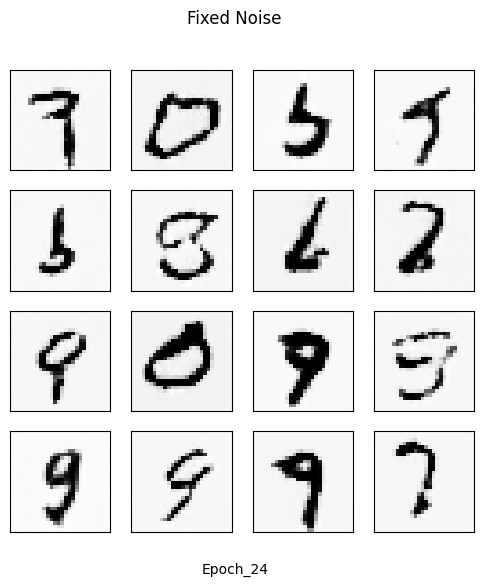

Epoch [25/50], Step [100/469], D Loss: 0.1447, G Loss: 4.4967, D(x): 0.94, D(G(z)): 0.07/0.03
Epoch [25/50], Step [200/469], D Loss: 0.1504, G Loss: 2.8466, D(x): 0.90, D(G(z)): 0.03/0.10
Epoch [25/50], Step [300/469], D Loss: 0.1493, G Loss: 3.9003, D(x): 0.92, D(G(z)): 0.06/0.04
Epoch [25/50], Step [400/469], D Loss: 0.5438, G Loss: 3.2897, D(x): 0.98, D(G(z)): 0.33/0.08


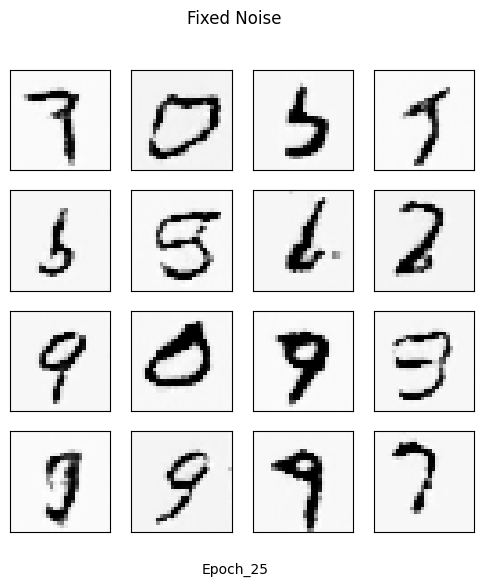

Epoch [26/50], Step [100/469], D Loss: 0.2823, G Loss: 3.6311, D(x): 0.94, D(G(z)): 0.17/0.05
Epoch [26/50], Step [200/469], D Loss: 0.1952, G Loss: 4.1149, D(x): 0.86, D(G(z)): 0.02/0.04
Epoch [26/50], Step [300/469], D Loss: 0.1718, G Loss: 3.5433, D(x): 0.92, D(G(z)): 0.06/0.08
Epoch [26/50], Step [400/469], D Loss: 0.1095, G Loss: 4.4287, D(x): 0.99, D(G(z)): 0.09/0.03


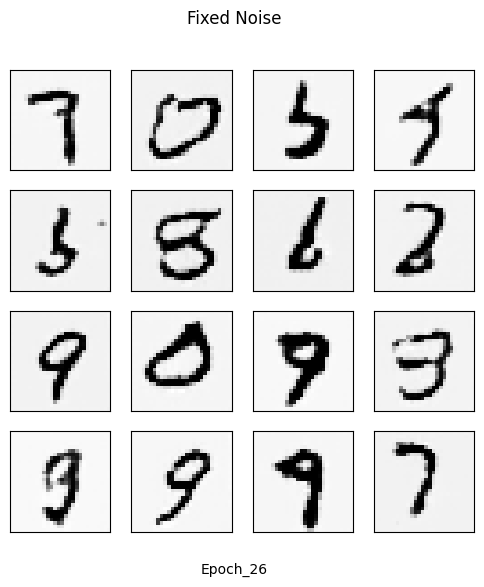

Epoch [27/50], Step [100/469], D Loss: 0.0945, G Loss: 4.0376, D(x): 0.95, D(G(z)): 0.04/0.04
Epoch [27/50], Step [200/469], D Loss: 0.1409, G Loss: 3.2991, D(x): 0.94, D(G(z)): 0.07/0.06
Epoch [27/50], Step [300/469], D Loss: 0.3173, G Loss: 1.8359, D(x): 0.90, D(G(z)): 0.16/0.24
Epoch [27/50], Step [400/469], D Loss: 0.4866, G Loss: 4.1912, D(x): 0.78, D(G(z)): 0.17/0.03


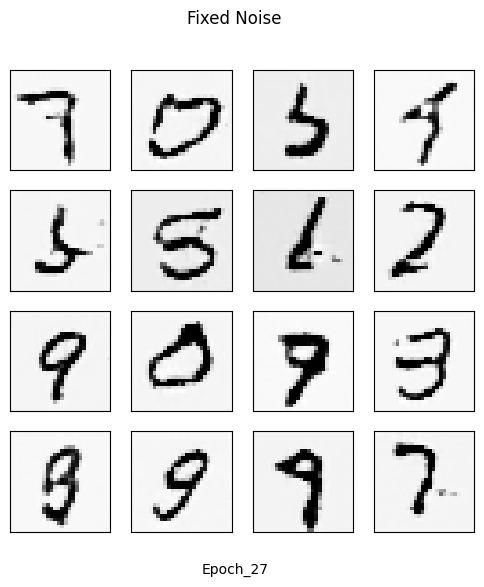

Epoch [28/50], Step [100/469], D Loss: 0.2349, G Loss: 3.1909, D(x): 0.99, D(G(z)): 0.17/0.09
Epoch [28/50], Step [200/469], D Loss: 0.2694, G Loss: 1.9454, D(x): 0.84, D(G(z)): 0.06/0.24
Epoch [28/50], Step [300/469], D Loss: 0.1120, G Loss: 3.9300, D(x): 0.93, D(G(z)): 0.03/0.04
Epoch [28/50], Step [400/469], D Loss: 0.0739, G Loss: 3.6450, D(x): 0.96, D(G(z)): 0.03/0.05


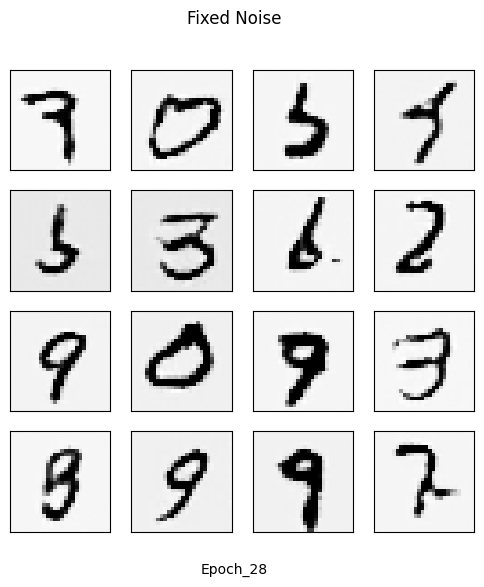

Epoch [29/50], Step [100/469], D Loss: 0.9235, G Loss: 1.9874, D(x): 0.51, D(G(z)): 0.05/0.21
Epoch [29/50], Step [200/469], D Loss: 0.2437, G Loss: 2.1604, D(x): 0.96, D(G(z)): 0.16/0.19
Epoch [29/50], Step [300/469], D Loss: 0.1236, G Loss: 3.6319, D(x): 0.99, D(G(z)): 0.09/0.06
Epoch [29/50], Step [400/469], D Loss: 0.3142, G Loss: 2.6975, D(x): 0.99, D(G(z)): 0.23/0.12


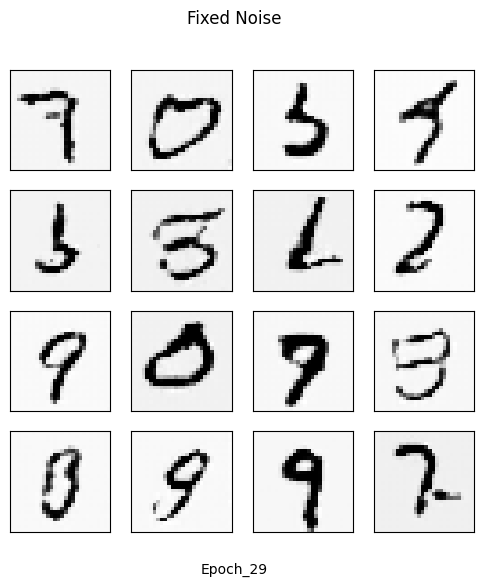

Epoch [30/50], Step [100/469], D Loss: 0.0616, G Loss: 4.0734, D(x): 0.97, D(G(z)): 0.03/0.04
Epoch [30/50], Step [200/469], D Loss: 0.0484, G Loss: 6.4709, D(x): 0.96, D(G(z)): 0.01/0.00
Epoch [30/50], Step [300/469], D Loss: 0.3149, G Loss: 5.5308, D(x): 0.99, D(G(z)): 0.23/0.01
Epoch [30/50], Step [400/469], D Loss: 0.1625, G Loss: 3.1936, D(x): 0.97, D(G(z)): 0.10/0.09


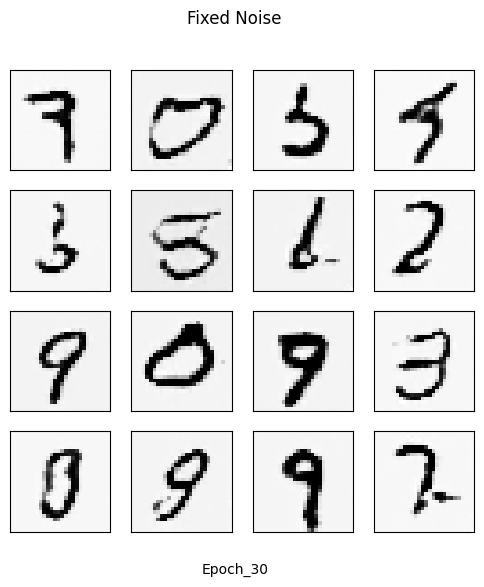

Epoch [31/50], Step [100/469], D Loss: 0.1363, G Loss: 3.8369, D(x): 0.97, D(G(z)): 0.09/0.04
Epoch [31/50], Step [200/469], D Loss: 0.2901, G Loss: 4.2812, D(x): 0.84, D(G(z)): 0.08/0.03
Epoch [31/50], Step [300/469], D Loss: 0.2175, G Loss: 2.3082, D(x): 0.97, D(G(z)): 0.15/0.16
Epoch [31/50], Step [400/469], D Loss: 0.0449, G Loss: 4.7566, D(x): 0.97, D(G(z)): 0.01/0.03


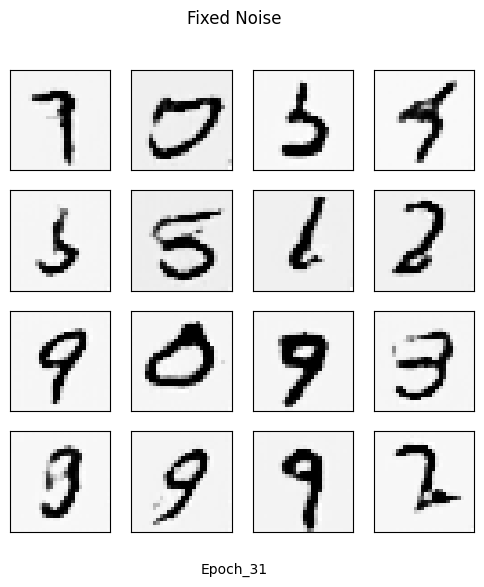

Epoch [32/50], Step [100/469], D Loss: 0.0329, G Loss: 5.0390, D(x): 0.99, D(G(z)): 0.02/0.02
Epoch [32/50], Step [200/469], D Loss: 0.1466, G Loss: 6.0030, D(x): 0.91, D(G(z)): 0.04/0.01
Epoch [32/50], Step [300/469], D Loss: 0.1015, G Loss: 4.0839, D(x): 0.93, D(G(z)): 0.02/0.04
Epoch [32/50], Step [400/469], D Loss: 0.2391, G Loss: 4.1457, D(x): 0.83, D(G(z)): 0.02/0.03


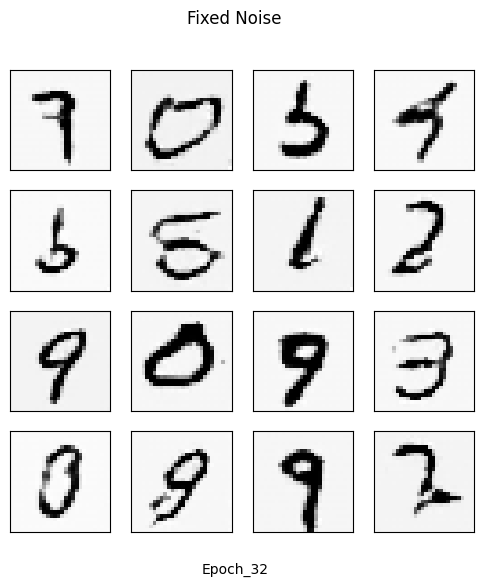

Epoch [33/50], Step [100/469], D Loss: 0.1032, G Loss: 4.3543, D(x): 1.00, D(G(z)): 0.09/0.03
Epoch [33/50], Step [200/469], D Loss: 0.2121, G Loss: 2.4297, D(x): 0.98, D(G(z)): 0.15/0.16
Epoch [33/50], Step [300/469], D Loss: 0.2738, G Loss: 3.0406, D(x): 0.94, D(G(z)): 0.16/0.10
Epoch [33/50], Step [400/469], D Loss: 0.1472, G Loss: 3.7060, D(x): 0.95, D(G(z)): 0.08/0.05


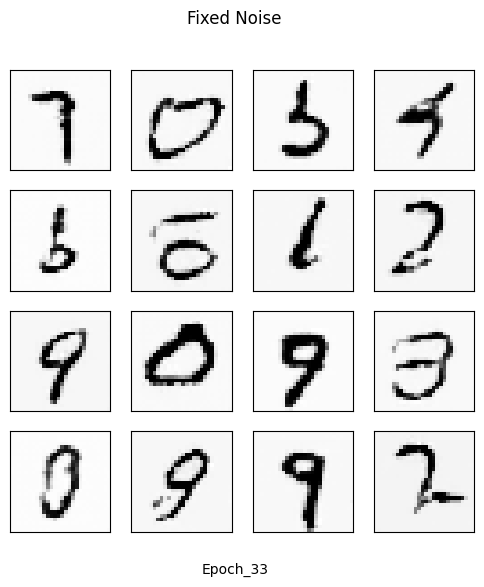

Epoch [34/50], Step [100/469], D Loss: 0.5216, G Loss: 8.0104, D(x): 0.65, D(G(z)): 0.00/0.00
Epoch [34/50], Step [200/469], D Loss: 0.1055, G Loss: 5.0415, D(x): 0.93, D(G(z)): 0.03/0.02
Epoch [34/50], Step [300/469], D Loss: 0.3733, G Loss: 3.5541, D(x): 0.91, D(G(z)): 0.20/0.06
Epoch [34/50], Step [400/469], D Loss: 0.2264, G Loss: 3.8140, D(x): 0.85, D(G(z)): 0.04/0.04


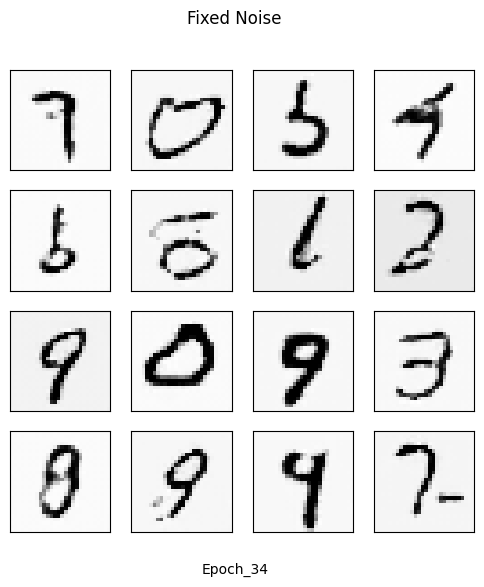

Epoch [35/50], Step [100/469], D Loss: 0.1958, G Loss: 1.7248, D(x): 0.99, D(G(z)): 0.16/0.25
Epoch [35/50], Step [200/469], D Loss: 0.1891, G Loss: 5.0114, D(x): 0.86, D(G(z)): 0.02/0.01
Epoch [35/50], Step [300/469], D Loss: 0.1437, G Loss: 3.7289, D(x): 0.93, D(G(z)): 0.06/0.04
Epoch [35/50], Step [400/469], D Loss: 0.1343, G Loss: 2.7860, D(x): 0.97, D(G(z)): 0.09/0.11


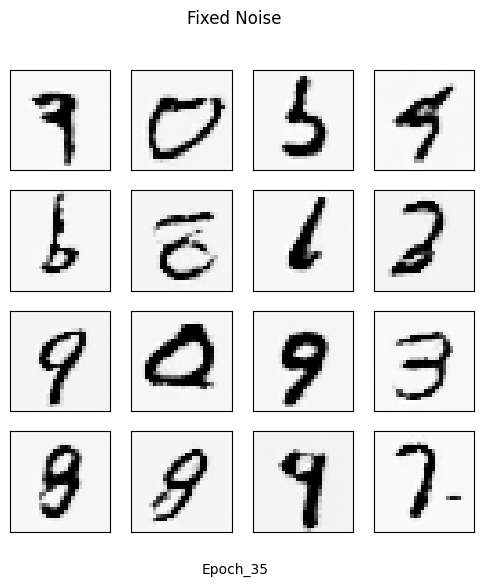

Epoch [36/50], Step [100/469], D Loss: 0.1872, G Loss: 2.8830, D(x): 0.89, D(G(z)): 0.05/0.10
Epoch [36/50], Step [200/469], D Loss: 0.2228, G Loss: 3.3634, D(x): 0.88, D(G(z)): 0.07/0.07
Epoch [36/50], Step [300/469], D Loss: 0.0584, G Loss: 4.4699, D(x): 0.99, D(G(z)): 0.04/0.03
Epoch [36/50], Step [400/469], D Loss: 0.1537, G Loss: 3.2833, D(x): 0.98, D(G(z)): 0.12/0.07


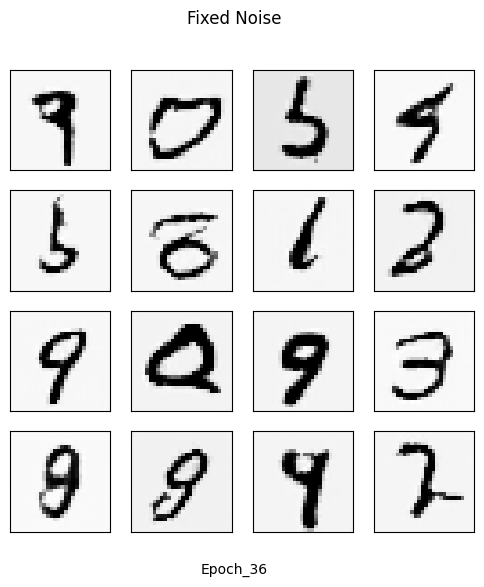

Epoch [37/50], Step [100/469], D Loss: 0.3267, G Loss: 2.8952, D(x): 0.85, D(G(z)): 0.12/0.09
Epoch [37/50], Step [200/469], D Loss: 0.4565, G Loss: 4.2131, D(x): 0.92, D(G(z)): 0.25/0.04
Epoch [37/50], Step [300/469], D Loss: 0.2696, G Loss: 2.6830, D(x): 0.86, D(G(z)): 0.09/0.10
Epoch [37/50], Step [400/469], D Loss: 0.1226, G Loss: 4.8607, D(x): 0.93, D(G(z)): 0.04/0.02


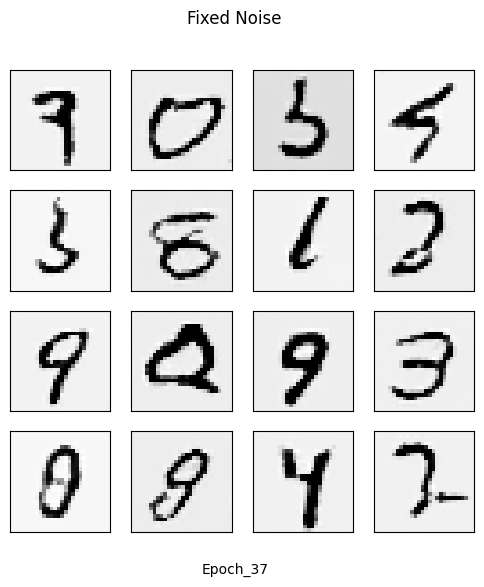

Epoch [38/50], Step [100/469], D Loss: 0.0914, G Loss: 4.8376, D(x): 0.93, D(G(z)): 0.01/0.02
Epoch [38/50], Step [200/469], D Loss: 0.2276, G Loss: 1.9290, D(x): 0.95, D(G(z)): 0.15/0.22
Epoch [38/50], Step [300/469], D Loss: 0.3495, G Loss: 3.3871, D(x): 0.89, D(G(z)): 0.17/0.06
Epoch [38/50], Step [400/469], D Loss: 0.4402, G Loss: 2.9549, D(x): 0.72, D(G(z)): 0.02/0.10


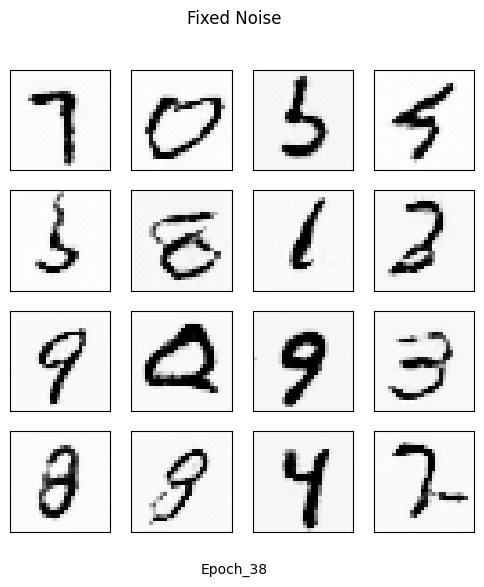

Epoch [39/50], Step [100/469], D Loss: 0.1893, G Loss: 2.5643, D(x): 0.99, D(G(z)): 0.14/0.12
Epoch [39/50], Step [200/469], D Loss: 0.1029, G Loss: 5.3539, D(x): 0.93, D(G(z)): 0.03/0.01
Epoch [39/50], Step [300/469], D Loss: 0.0662, G Loss: 4.9872, D(x): 0.98, D(G(z)): 0.04/0.01
Epoch [39/50], Step [400/469], D Loss: 0.1933, G Loss: 2.2820, D(x): 0.90, D(G(z)): 0.07/0.17


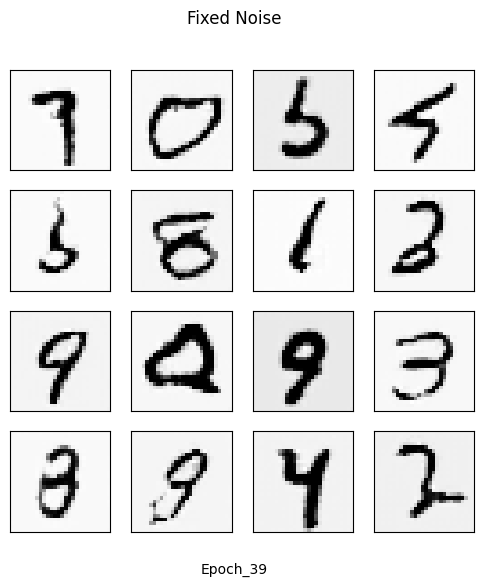

Epoch [40/50], Step [100/469], D Loss: 0.1854, G Loss: 4.4223, D(x): 0.88, D(G(z)): 0.03/0.03
Epoch [40/50], Step [200/469], D Loss: 0.3795, G Loss: 3.0017, D(x): 0.94, D(G(z)): 0.25/0.08
Epoch [40/50], Step [300/469], D Loss: 0.1210, G Loss: 3.5533, D(x): 0.99, D(G(z)): 0.09/0.06
Epoch [40/50], Step [400/469], D Loss: 0.4591, G Loss: 3.3602, D(x): 0.71, D(G(z)): 0.04/0.08


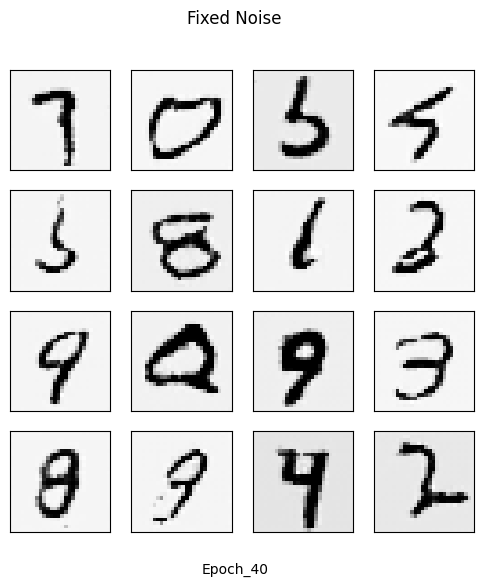

Epoch [41/50], Step [100/469], D Loss: 0.3081, G Loss: 3.5512, D(x): 0.83, D(G(z)): 0.08/0.06
Epoch [41/50], Step [200/469], D Loss: 0.0869, G Loss: 3.4829, D(x): 0.96, D(G(z)): 0.04/0.07
Epoch [41/50], Step [300/469], D Loss: 0.3091, G Loss: 1.8568, D(x): 0.98, D(G(z)): 0.21/0.24
Epoch [41/50], Step [400/469], D Loss: 0.5632, G Loss: 2.9839, D(x): 0.65, D(G(z)): 0.03/0.10


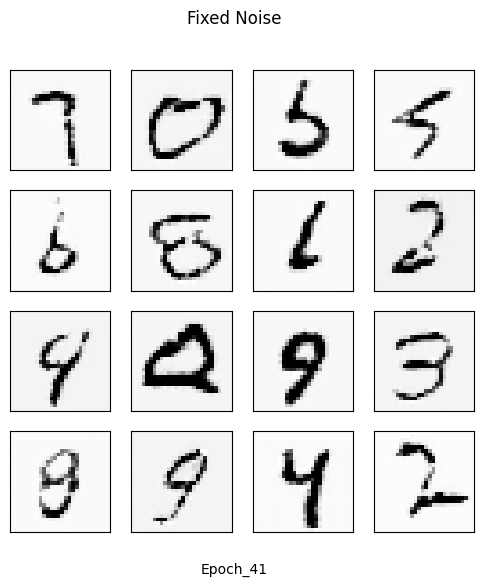

Epoch [42/50], Step [100/469], D Loss: 0.1180, G Loss: 2.4879, D(x): 0.97, D(G(z)): 0.08/0.14
Epoch [42/50], Step [200/469], D Loss: 0.3337, G Loss: 2.8541, D(x): 0.89, D(G(z)): 0.16/0.11
Epoch [42/50], Step [300/469], D Loss: 0.3786, G Loss: 3.2118, D(x): 0.73, D(G(z)): 0.02/0.08
Epoch [42/50], Step [400/469], D Loss: 0.2461, G Loss: 3.6169, D(x): 0.86, D(G(z)): 0.07/0.05


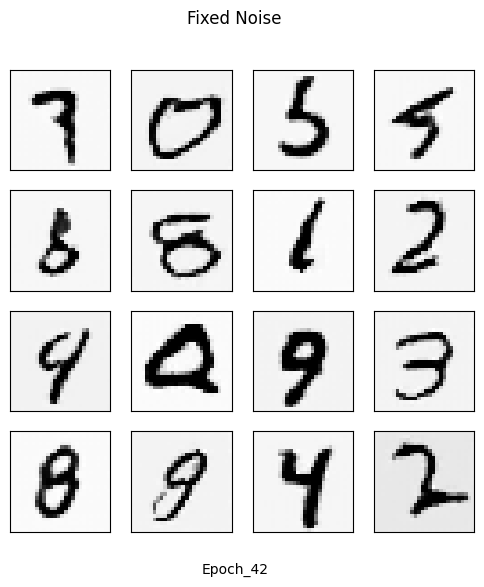

Epoch [43/50], Step [100/469], D Loss: 0.2424, G Loss: 2.7855, D(x): 0.96, D(G(z)): 0.17/0.09
Epoch [43/50], Step [200/469], D Loss: 0.2503, G Loss: 2.5065, D(x): 0.91, D(G(z)): 0.13/0.12
Epoch [43/50], Step [300/469], D Loss: 0.2595, G Loss: 1.9043, D(x): 0.87, D(G(z)): 0.10/0.21
Epoch [43/50], Step [400/469], D Loss: 0.1810, G Loss: 2.1381, D(x): 0.91, D(G(z)): 0.06/0.18


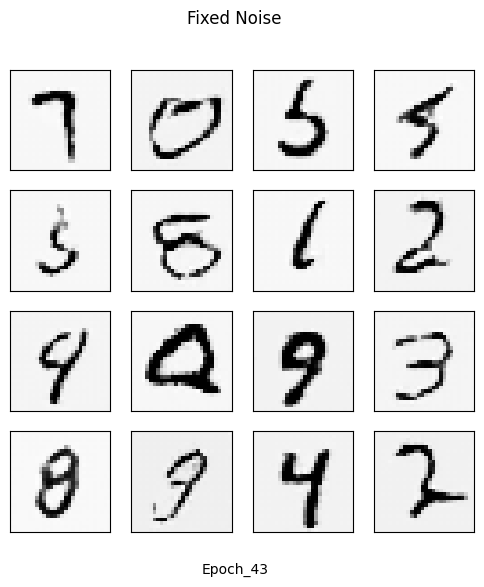

Epoch [44/50], Step [100/469], D Loss: 0.2201, G Loss: 2.7576, D(x): 0.97, D(G(z)): 0.16/0.12
Epoch [44/50], Step [200/469], D Loss: 0.2847, G Loss: 2.7835, D(x): 0.94, D(G(z)): 0.18/0.09
Epoch [44/50], Step [300/469], D Loss: 0.1304, G Loss: 4.3933, D(x): 0.94, D(G(z)): 0.05/0.03
Epoch [44/50], Step [400/469], D Loss: 0.4124, G Loss: 2.7187, D(x): 0.91, D(G(z)): 0.22/0.12


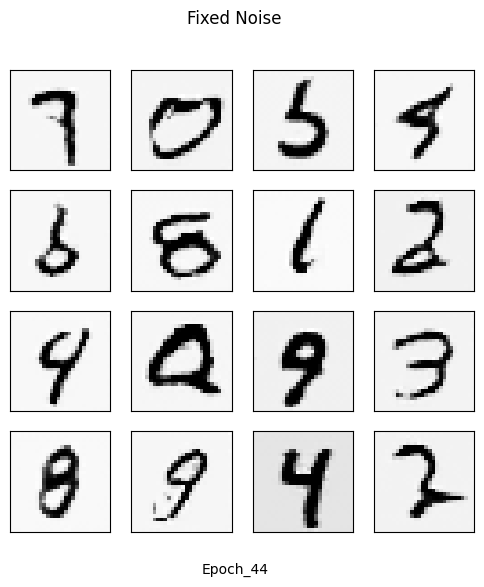

Epoch [45/50], Step [100/469], D Loss: 0.2866, G Loss: 3.6509, D(x): 0.97, D(G(z)): 0.19/0.06
Epoch [45/50], Step [200/469], D Loss: 0.1182, G Loss: 3.7745, D(x): 0.93, D(G(z)): 0.04/0.04
Epoch [45/50], Step [300/469], D Loss: 0.1095, G Loss: 3.4560, D(x): 0.95, D(G(z)): 0.05/0.06
Epoch [45/50], Step [400/469], D Loss: 0.4628, G Loss: 2.3968, D(x): 0.99, D(G(z)): 0.31/0.15


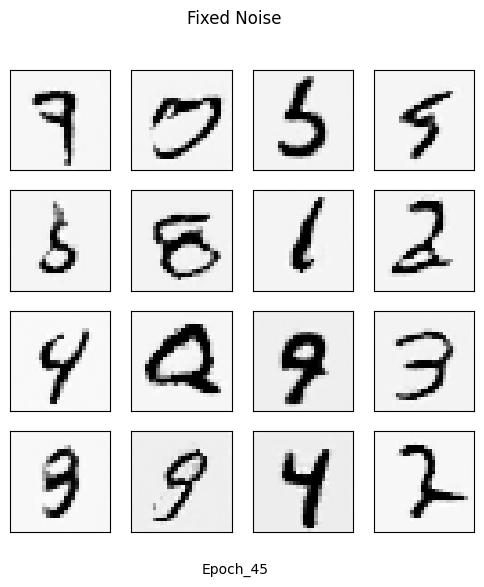

Epoch [46/50], Step [100/469], D Loss: 0.3581, G Loss: 1.7497, D(x): 0.92, D(G(z)): 0.21/0.25
Epoch [46/50], Step [200/469], D Loss: 0.1134, G Loss: 4.4621, D(x): 0.98, D(G(z)): 0.08/0.03
Epoch [46/50], Step [300/469], D Loss: 0.2305, G Loss: 4.1003, D(x): 0.95, D(G(z)): 0.15/0.03
Epoch [46/50], Step [400/469], D Loss: 0.3077, G Loss: 4.2204, D(x): 0.80, D(G(z)): 0.04/0.03


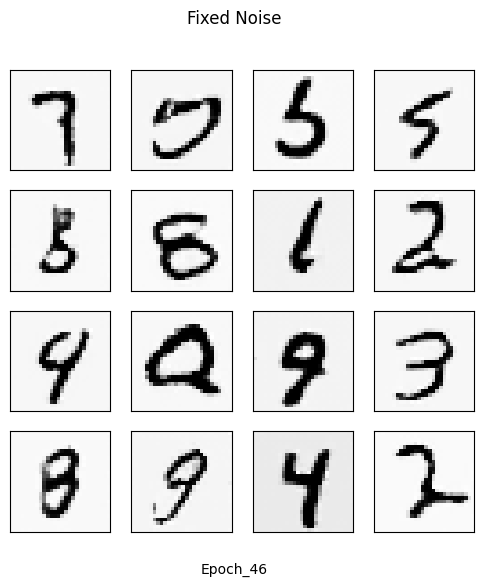

Epoch [47/50], Step [100/469], D Loss: 0.3507, G Loss: 4.7915, D(x): 0.75, D(G(z)): 0.02/0.02
Epoch [47/50], Step [200/469], D Loss: 0.3719, G Loss: 3.7975, D(x): 1.00, D(G(z)): 0.27/0.04
Epoch [47/50], Step [300/469], D Loss: 0.8795, G Loss: 5.4680, D(x): 0.48, D(G(z)): 0.00/0.01
Epoch [47/50], Step [400/469], D Loss: 0.1382, G Loss: 3.0812, D(x): 0.95, D(G(z)): 0.08/0.08


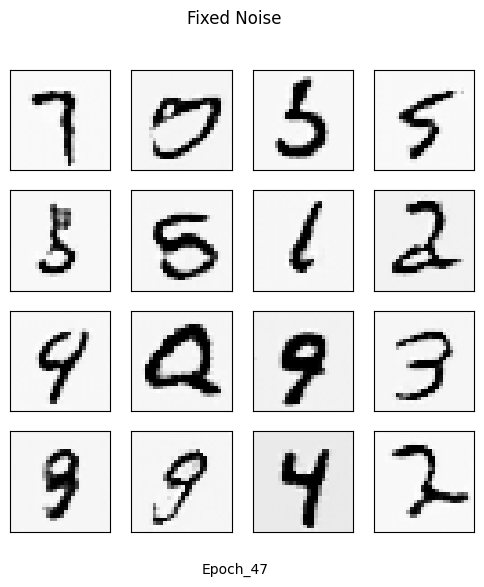

Epoch [48/50], Step [100/469], D Loss: 0.1404, G Loss: 7.1841, D(x): 0.89, D(G(z)): 0.01/0.00
Epoch [48/50], Step [200/469], D Loss: 0.1577, G Loss: 3.6243, D(x): 0.89, D(G(z)): 0.03/0.06
Epoch [48/50], Step [300/469], D Loss: 0.2533, G Loss: 2.5985, D(x): 0.97, D(G(z)): 0.18/0.13
Epoch [48/50], Step [400/469], D Loss: 0.2137, G Loss: 2.8629, D(x): 0.92, D(G(z)): 0.11/0.09


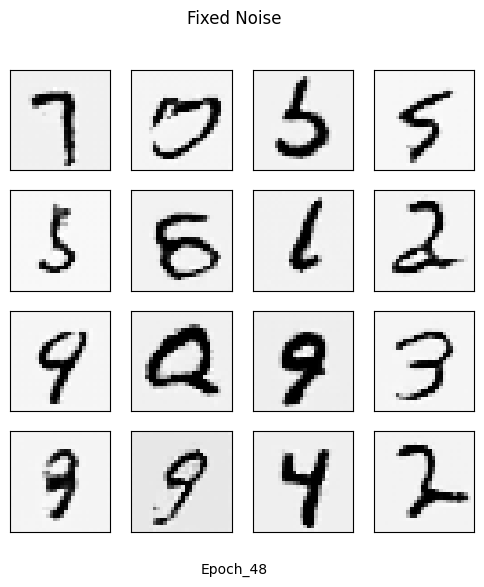

Epoch [49/50], Step [100/469], D Loss: 0.1241, G Loss: 2.6372, D(x): 0.96, D(G(z)): 0.07/0.12
Epoch [49/50], Step [200/469], D Loss: 0.0940, G Loss: 4.3249, D(x): 0.95, D(G(z)): 0.04/0.02
Epoch [49/50], Step [300/469], D Loss: 0.1737, G Loss: 3.5148, D(x): 0.96, D(G(z)): 0.11/0.06
Epoch [49/50], Step [400/469], D Loss: 0.1532, G Loss: 2.1160, D(x): 0.98, D(G(z)): 0.12/0.18


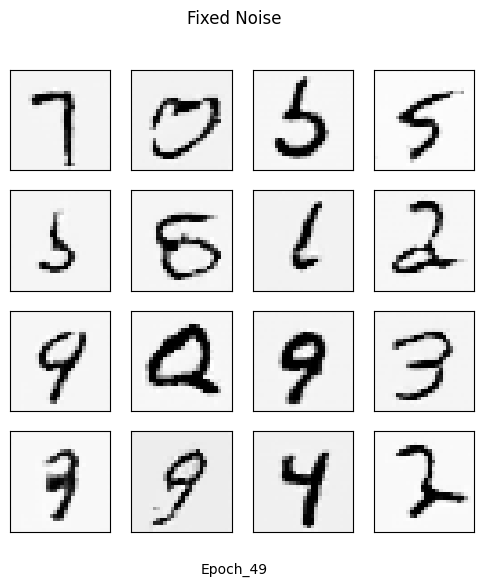

Epoch [50/50], Step [100/469], D Loss: 0.1067, G Loss: 3.8002, D(x): 0.93, D(G(z)): 0.03/0.05
Epoch [50/50], Step [200/469], D Loss: 0.1271, G Loss: 5.7388, D(x): 0.90, D(G(z)): 0.01/0.01
Epoch [50/50], Step [300/469], D Loss: 0.2040, G Loss: 3.9142, D(x): 0.86, D(G(z)): 0.04/0.04
Epoch [50/50], Step [400/469], D Loss: 0.2846, G Loss: 3.1110, D(x): 0.98, D(G(z)): 0.20/0.09


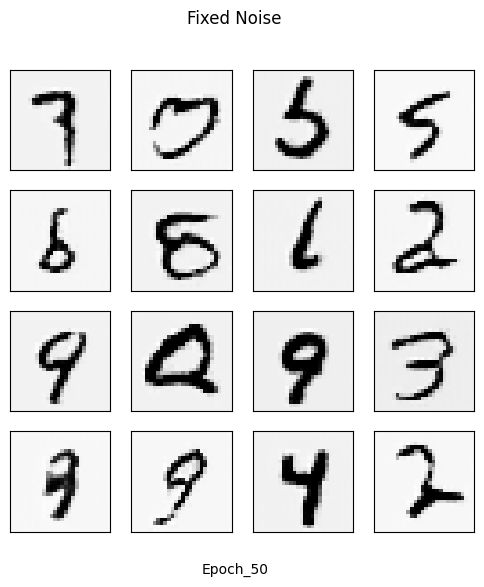

In [14]:
# Configuration variables
num_epochs = 50
ndf = 32  # Number of features in the Discriminator
ngf = 32  # Number of features in the Generator
nz = 100  # Size of the noise
nc = 1  # Number of input channels (e.g., grayscale: 1, RGB: 3)
batch_size = 128  # Batch size
d_lr = 0.0003  # Learning rate for the Discriminator
g_lr = 0.0003  # Learning rate for the Generator
num_test_samples = 16  # Number of samples to visualize
output_path = './results/'  # Path to save the images

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using", device)

# Define Discriminator and Generator architectures
netG = Generator(nc, nz, ngf).to(device)
netD = Discriminator(nc, ndf).to(device)

# Loss function
criterion = nn.BCELoss()

# Optimizers
optimizerD = optim.Adam(netD.parameters(), lr=d_lr)
optimizerG = optim.Adam(netG.parameters(), lr=g_lr)

# Initialize other variables
real_label = 1
fake_label = 0
num_batches = len(train_loader)
fixed_noise = torch.randn(num_test_samples, nz, 1, 1, device=device)

for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(train_loader):
        bs = real_images.shape[0]


        # Train discriminator
        netD.zero_grad()
        real_images = real_images.to(device)
        label = torch.full((bs,), real_label, device=device)

        output = netD(real_images)
        lossD_real = criterion(output, label.float())
        lossD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(bs, nz, 1, 1, device=device)
        fake_images = netG(noise)
        label.fill_(fake_label)
        output = netD(fake_images.detach())
        lossD_fake = criterion(output, label.float())
        lossD_fake.backward()
        D_G_z1 = output.mean().item()
        lossD = lossD_real + lossD_fake
        optimizerD.step()


        # Train generator
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake_images)
        lossG = criterion(output, label.float())
        lossG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if (i + 1) % 100 == 0:
            print(
                'Epoch [{}/{}], Step [{}/{}], D Loss: {:.4f}, G Loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}/{:.2f}'
                .format(epoch + 1, num_epochs, i + 1, num_batches, lossD.item(), lossG.item(), D_x, D_G_z1, D_G_z2)
            )

    # Generate images for visualization
    netG.eval()
    display_generated_images(epoch, fixed_noise, num_test_samples, netG, device)
    netG.train()


### Part 4: Plot a grid of 100 generated samples.

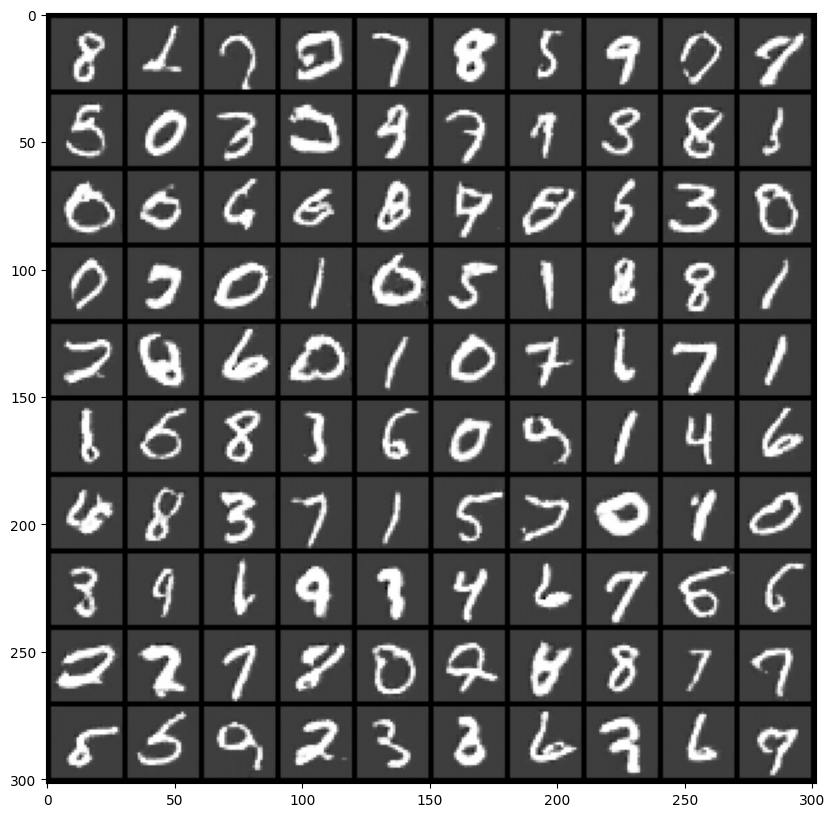

In [56]:
def plot_samples(samples):
    samples = (samples + 1) / 2.0
    samples = samples.view(-1, 1, 28, 28)
    grid = np.transpose(torchvision.utils.make_grid(samples, nrow=10, padding=2, normalize=True).cpu(), (1, 2, 0))
    plt.figure(figsize=(10, 10))
    plt.imshow(grid)
    plt.show()

netG.eval()

with torch.no_grad():
    noise = torch.randn(100, nz, 1, 1, device=device)
    samples = netG(noise).cpu()
    plot_samples(samples)

### Part 5: GAN Inversion
In this part, we aim to find the latent vectors corresponding to the samples in the dataset. First, select a random sample from the real dataset and a random latent vector. Freeze the generator and feed the random latent vector into the Generator. Next, define an MSE or MAE loss between the generated sample and the real sample, and optimize the random latent vector to discover the latent vector that generates the selected real sample.


In [39]:
def gan_inversion(generator, real_image, latent_dim, iterations=1000, lr=0.01):

    real_image = real_image.unsqueeze(0).to(device)
    latent_vector = torch.randn(1, latent_dim, 1, 1, requires_grad=True, device=device)
    optimizer = optim.Adam([latent_vector], lr=lr)
    criterion = nn.L1Loss()

    for i in range(iterations):
        optimizer.zero_grad()
        generated_image = generator(latent_vector)
        loss = criterion(generated_image, real_image)
        loss.backward()
        optimizer.step()
        if (i + 1) % 1000 == 0:
            print(f"Iteration {i + 1}/{iterations}, Loss: {loss.item()}")
    return latent_vector

sample_real_image, _ = train_dataset[0]

latent_vector = gan_inversion(netG, sample_real_image, nz, 5000)

print('latent vector is:', latent_vector)


Iteration 1000/5000, Loss: 0.47390875220298767
Iteration 2000/5000, Loss: 0.4536292254924774
Iteration 3000/5000, Loss: 0.4530094861984253
Iteration 4000/5000, Loss: 0.45186474919319153
Iteration 5000/5000, Loss: 0.45100319385528564
latent vector is: tensor([[[[ 1.0207]],

         [[ 0.3660]],

         [[-0.9222]],

         [[-1.2328]],

         [[-1.9065]],

         [[-1.4765]],

         [[-0.1157]],

         [[-0.1005]],

         [[ 2.3840]],

         [[-2.6038]],

         [[ 1.3156]],

         [[ 0.0943]],

         [[-2.1643]],

         [[-0.3678]],

         [[-2.1527]],

         [[-0.6237]],

         [[-0.5744]],

         [[ 1.2340]],

         [[-1.7398]],

         [[-1.2498]],

         [[-1.2652]],

         [[ 0.0660]],

         [[ 1.9267]],

         [[-0.8411]],

         [[ 0.0512]],

         [[ 1.0135]],

         [[ 2.4458]],

         [[-2.4182]],

         [[ 1.6723]],

         [[ 1.3010]],

         [[-0.6060]],

         [[-2.1284]],

         [[-1

### Part 6: Interpolating the Latent Space
In this part, you will interpolate the latent space using a 10 by 10 grid. Start with 4 initial points representing the corners of the square, and then perform linear or spherical interpolation between the latent vectors of these 4 images to fill the circumference of the square.
Next, fill in the rest of the square by interpolating between the latent vectors along the circumference.

If $G$ is the generator, and $z_1$ and $z_2$ are two latent vectors of two images, let $w$ be a parameter that varies between $0$ and $1$. The linearly interpolated sample is generated as:

\begin{equation}
G(w \cdot z_1 + (1 - w) \cdot z_2)\
\end{equation}

Try to select the 4 starting images from those that exhibit distinct features. For example, the two top right corners could be the same digit but one with a thick stroke and the other with a thin stroke, while the other two points should be from a different digit but with varying stroke styles.

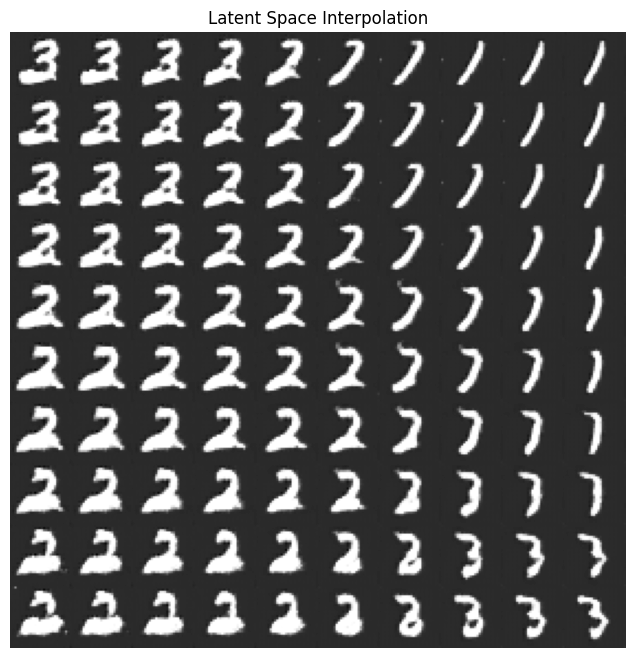

In [40]:
def generate_latent_vectors(latent_dim, device):
    """Generates four random latent vectors for the corners of the grid."""
    return [torch.randn(1, latent_dim, 1, 1, device=device) for _ in range(4)]

def interpolate_two_vectors(v1, v2, alpha):

    return alpha * v1 + (1 - alpha) * v2

def interpolate_grid_row(z_top, z_bottom, grid_size):

    row_images = []
    for col in range(grid_size):
        alpha_col = col / (grid_size - 1)
        z_interp = interpolate_two_vectors(z_top, z_bottom, alpha_col)
        row_images.append(z_interp)
    return row_images

def generate_image_grid(generator, latent_vectors, latent_dim, grid_size, device):

    z1, z2, z3, z4 = latent_vectors

    grid_images = []
    for row in range(grid_size):
        alpha_row = row / (grid_size - 1)
        z_top = interpolate_two_vectors(z1, z2, alpha_row)
        z_bottom = interpolate_two_vectors(z3, z4, alpha_row)

        row_images = []
        for z_interp in interpolate_grid_row(z_top, z_bottom, grid_size):
            with torch.no_grad():
                generated_image = generator(z_interp).cpu()
                row_images.append(generated_image)

        grid_images.append(torch.cat(row_images, dim=3))

    final_grid = torch.cat(grid_images, dim=2)
    return final_grid

def plot_image_grid(image_grid):

    # scale images to [0, 1]
    image_grid = (image_grid + 1) / 2.0
    image_grid = image_grid.squeeze(0).permute(1, 2, 0).numpy()
    plt.figure(figsize=(8, 8))
    plt.imshow(image_grid, cmap="gray")
    plt.axis("off")
    plt.title("Latent Space Interpolation")
    plt.show()


def interpolate_latent_space(generator, latent_dim, grid_size=10, device="cpu"):
    latent_vectors = generate_latent_vectors(latent_dim, device)
    image_grid = generate_image_grid(generator, latent_vectors, latent_dim, grid_size, device)
    plot_image_grid(image_grid)


interpolate_latent_space(netG, nz, grid_size=10, device=device)


### Part 7: Arithmetic Operation in Latent Space
In this part, you will attempt to modify the thickness or thinness of a sample by identifying the direction in the latent space that corresponds to these attributes. Additionally, you can explore changing a digit to another (e.g., transforming a digit into a 3) by finding the direction in the latent space that corresponds to that digit.


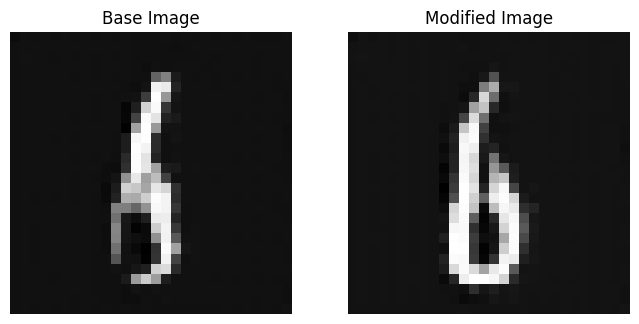

In [54]:
import torch
import matplotlib.pyplot as plt

def generate_latent_vector(latent_dim, device):

    return torch.randn(1, latent_dim, 1, 1, device=device)

def generate_image(generator, latent_vector):
    with torch.no_grad():
        image = generator(latent_vector).cpu()
    return (image + 1) / 2.0

def plot_images(base_image, modified_image):

    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(base_image.squeeze(0).permute(1, 2, 0), cmap="gray")
    ax[0].set_title("Base Image")
    ax[0].axis("off")
    ax[1].imshow(modified_image.squeeze(0).permute(1, 2, 0), cmap="gray")
    ax[1].set_title("Modified Image")
    ax[1].axis("off")
    plt.show()

def latent_arithmetic(generator, latent_dim, device, attribute_diff):

    base_latent = generate_latent_vector(latent_dim, device)
    modified_latent = base_latent + attribute_diff

    base_image = generate_image(generator, base_latent)
    modified_image = generate_image(generator, modified_latent)

    plot_images(base_image, modified_image)

def find_attribute_direction(generator, latent_dim, device, n_samples=10):

    direction = torch.zeros((1, latent_dim, 1, 1), device=device)
    for _ in range(n_samples):
        z1 = generate_latent_vector(latent_dim, device)
        z2 = generate_latent_vector(latent_dim, device)

        direction += (z2 - z1)

    return direction / n_samples

attribute_direction = find_attribute_direction(netG, nz, device, n_samples=10)
latent_arithmetic(netG, nz, device, attribute_direction)
